## 1. 패키지 로드

In [114]:
import pandas as pd
import numpy as np
import re
from sklearn.metrics.pairwise import cosine_similarity
import cv2
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import dlib

## 2. 이미지 비교 클래스

In [160]:
class CImg:

    def __init__(self):
        '''init class'''
        self.knn_image = None
        pass
  
    def img_to_rgb(self, image):
        '''convert image to rgb'''
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        return image

    def img_to_bgr(self, image):
        '''convert image to bgr'''
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        return image

    def img_adjust(self, image, brightness = 0, contrast = 30):
        '''adjust image'''
        image = np.int16(image)
        image = image * (contrast / 127 + 1) - contrast + brightness
        image = np.clip(image, 0, 255)
        image = np.uint8(image)

        return image

    def img_resize(self, image, size = 256):
        '''resize image'''
        image = cv2.resize(image, (size, size))

        return image
  
    def img_face_align(self, image, size = 256, padding = 0.65):
        '''face align image'''
        detector = dlib.get_frontal_face_detector()
        sp = dlib.shape_predictor('../util/shape_predictor_5_face_landmarks.dat')
        dets = detector(image)
        if dets:
            pass
        else:
            #print("No detect face")
            return image
        s = sp(image, dets[0])
        image = dlib.get_face_chip(image, s, size=size, padding=padding)

        return image

    def img_compare(self, image_1, image_2, ratio=0.75, show=False):
        '''compare image'''
        # Initiate SIFT detector
        orb = cv2.ORB_create()

        # find the keypoints and descriptors with SIFT
        kp1, des1 = orb.detectAndCompute(image_1, None)
        kp2, des2 = orb.detectAndCompute(image_2, None)

        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors.
        matches = bf.match(des1,des2)

        # Sort them in the order of their distance.
        matches = sorted(matches, key = lambda x:x.distance)

        # BFMatcher with default params
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(des1, des2, k=2)

        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < ratio * n.distance:
                good.append([m])

        # Draw first 10 matches.
        knn_image = cv2.drawMatchesKnn(image_1, kp1, image_2, kp2, good, None, flags=2)
        self.knn_image = knn_image
        if show:
            plt.axis('off')
            plt.imshow(knn_image)
            plt.show()

        return len(good)
    
    def get_knn_image(self):
        return self.knn_image
    
    def img_show(self, image):
        '''show image'''
        plt.figure(figsize=(16, 10))
        plt.imshow(image)

    def run(self, image_1, image_2, size = 256, padding = 0.65, ratio = 0.75, brightness = 0, contrast = 30, show=False):
        '''run compare image'''
        image_1 = self.img_to_rgb(image_1)
        image_1 = self.img_adjust(image_1, brightness=brightness, contrast=contrast)
        image_1 = self.img_resize(image_1, size=size)
        image_1 = self.img_face_align(image_1, size=size, padding=padding)
        image_1 = self.img_to_bgr(image_1)
        image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)

        image_2 = self.img_to_rgb(image_2)
        image_2 = self.img_adjust(image_2, brightness=brightness, contrast=contrast)
        image_2 = self.img_resize(image_2, size=size)
        image_2 = self.img_face_align(image_2, size=size, padding=padding)
        image_2 = self.img_to_bgr(image_2)
        image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)

        n_similarity = self.img_compare(image_1, image_2, ratio=0.75, show=show)

        return n_similarity

## 3. 데이터 로드

In [146]:
# actor keyword data
actor_text_df = pd.read_csv('../text_data/actor_keywords.csv', encoding='utf-8-sig')
actor_text_df.head(2)

,Name,Age,Sex,5_keywords
0,감우성,52,남,"성장해, 부답인, 쎄냐고, 좋아하는데, 좋아했는데"
1,강경준,39,남,"당해서, 좋아해요, 재미있게, 불쌍해서, 좋아하는데"


In [148]:
# webtoon keyword data
webtoon_text_df = pd.read_csv('../text_data/webtoon_keywords.csv', encoding='utf-8-sig')
webtoon_text_df.head(2)

,Title,Character,Sex,Age,5_keywords
0,폭풍의전학생,주인공,남,10대,"진정한, 당하며, 뛰어난데, 태연한, 안되지만"
1,폭풍의전학생,최완서,남,10대,"강한, 좋아하는, 단련해서, 불쌍한, 험하다"


In [149]:
# image similarity data
image_score_df = pd.read_csv('../text_data/cos_sim_score_df.csv', encoding='utf-8-sig')
image_score_df.head(5)

,Name,Age,Sex,폭풍의전학생_주인공_image_score,폭풍의전학생_최완서_image_score,폭풍의전학생_김대용_image_score,폭풍의전학생_정해인_image_score,폭풍의전학생_황인규_image_score,폭풍의전학생_이연희_image_score,폭풍의전학생_조규식_image_score,...,노블레스_프랑켄슈타인_image_score,노블레스_레지스 K 란데그르_image_score,노블레스_세이라 J 로이아드_image_score,노블레스_라엘 케르티아_image_score,노블레스_카리어스 블러스터_image_score,노블레스_M-21_image_score,노블레스_타키오_image_score,노블레스_타오_image_score,전설의 레전드_전설_image_score,전설의 레전드_문태식_image_score
0,감우성,52,남,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.612988,NaN,NaN,NaN,NaN,NaN
1,강경준,39,남,NaN,NaN,NaN,NaN,NaN,NaN,0.586832,...,0.633482,NaN,NaN,0.533305,NaN,0.621947,0.544965,0.632591,NaN,0.725206
2,강기영,39,남,NaN,NaN,NaN,NaN,NaN,NaN,0.620132,...,0.658447,NaN,NaN,0.575278,NaN,0.642590,0.581335,0.662886,NaN,0.723405
3,강남길,64,남,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,강지섭,41,남,NaN,NaN,NaN,NaN,NaN,NaN,0.649044,...,0.689507,NaN,NaN,NaN,0.614106,NaN,NaN,NaN,NaN,NaN


## 4. 모델 로드

In [45]:
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

## 5. 추천

In [187]:
# 1. 사용자가 웹툰 제목 입력
user_input_title = input('웹툰 제목을 입력하세요 : ')

웹툰 제목을 입력하세요 : 폭풍의전학생


등장인물 이름 : 주인공


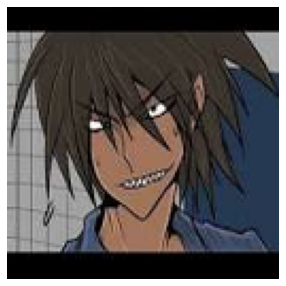

등장인물 이름 : 최완서


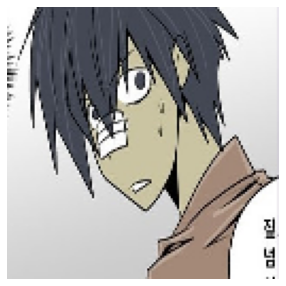

등장인물 이름 : 김대용


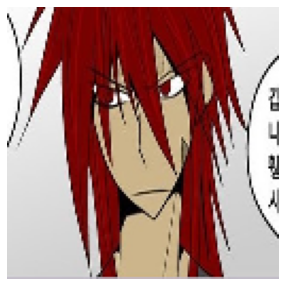

등장인물 이름 : 정해인


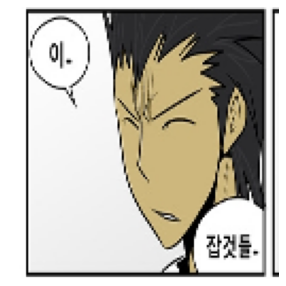

등장인물 이름 : 황인규


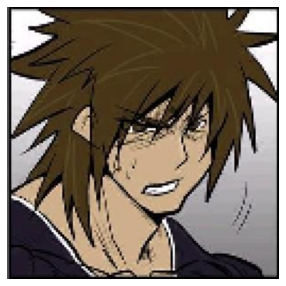

등장인물 이름 : 이연희


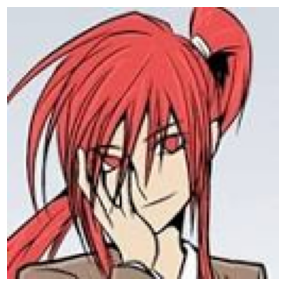

등장인물 이름 : 조규식


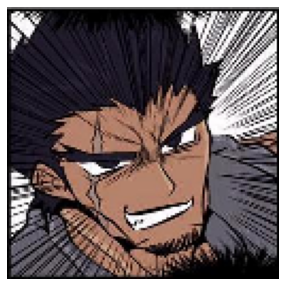

등장인물 이름 : 강창원


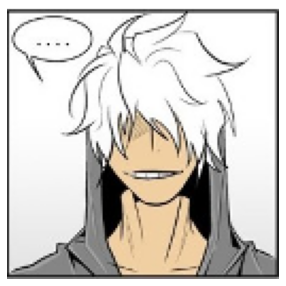

등장인물 이름 : 이승재


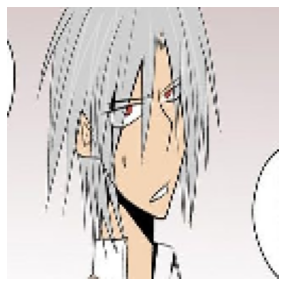

In [188]:
# 2. 입력한 웹툰에 해당하는 등장인물(사진, 이름 표시)
character_list = webtoon_text_df.loc[webtoon_text_df['Title'] == user_input_title, 'Character'].to_list()

for c_name in character_list:
    try:
        print(f'등장인물 이름 : {c_name}')
        c_img = cv2.imread(f'../image_data/Webtoon/{user_input_title}_{c_name}.jpg', flags=cv2.IMREAD_COLOR)
        c_img = cv2.resize(c_img, (128, 128), interpolation=cv2.INTER_CUBIC)
        c_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(8, 5))
        plt.imshow(c_img)
        plt.axis('off')
        plt.show()
    except:
        print(f'{c_name} 사진 없음')

In [189]:
# 3. 사용자가 등장인물을 하나 선택한다.
user_input_cname = input('등장인물을 선택하세요 : ')

등장인물을 선택하세요 : 이연희


## 6. 등장인물과 유사한 배우를 추천해준다.
- (표시 : 등장인물사진, 등장인물이름, 배우사진, 배우이름, 배우나이, 이미지 유사도 점수, 키워드 유사도 점수, 합산점수)

### 1) 키워드 유사도 구하기 + 이미지 유사도와 합산점수 구하기

In [190]:
# 필터링
character_sex = webtoon_text_df[webtoon_text_df['Character'] == user_input_cname]['Sex'].values[0]
character_age = webtoon_text_df[webtoon_text_df['Character'] == user_input_cname]['Age'].values[0]
character_age = int(re.sub('[^0-9]', '', character_age))
character_keyword = webtoon_text_df[webtoon_text_df['Character'] == user_input_cname]['5_keywords'].values[0]
character_keyword = character_keyword.split(', ')
character_keyword_vec = model.encode(character_keyword)
character_keyword_vec = character_keyword_vec.sum(axis=1) / len(character_keyword_vec)

In [191]:
actor_list = []

for actor_name in actor_text_df['Name']:
    actor_sex = actor_text_df[actor_text_df['Name'] == actor_name]['Sex'].values[0]
    actor_age = actor_text_df[actor_text_df['Name'] == actor_name]['Age'].values[0]

    # 성별 동일, 나이 범위에 포함되면 비교
    if (actor_sex == character_sex) and ((character_age < actor_age) and (character_age + 20 > actor_age)):
        actor_dict = dict()
        
        actor_keyword = actor_text_df[actor_text_df['Name'] == actor_name]['5_keywords'].values[0]
        actor_keyword = actor_keyword.split(', ')
        
        actor_keyword_vec = model.encode(actor_keyword)
        actor_keyword_vec = actor_keyword_vec.sum(axis=1) / len(actor_keyword_vec)
        
        keyword_score = cosine_similarity([character_keyword_vec], [actor_keyword_vec])[0][0]
        image_score = image_score_df[image_score_df['Name'] == actor_name][f'{user_input_title}_{user_input_cname}_image_score'].values[0]
        total_score = (0.5 * keyword_score) + (0.5 * image_score)
        
        actor_dict['Name'] = actor_name
        actor_dict['Age'] = actor_age
        actor_dict['image_score'] = image_score
        actor_dict['keyword_score'] = keyword_score
        actor_dict['total_score'] = total_score
        
        actor_list.append(actor_dict)

actors_score_df = pd.DataFrame(actor_list)

### 2) 배우 추천

In [192]:
top5_actors_df = actors_score_df.sort_values('total_score', ascending=False).iloc[:5].reset_index(drop=True)
top5_actors_df

,Name,Age,image_score,keyword_score,total_score
0,방민아,29,0.654531,0.993542,0.824037
1,채수빈,28,0.631104,0.995125,0.813115
2,김남주,27,0.628033,0.997923,0.812978
3,남지현,27,0.626814,0.992267,0.809541
4,혜리,28,0.620152,0.978087,0.799119


--------------------------------------------------------
순위 : 1
이름 : 방민아
나이 : 29
이미지 점수 : 65.45
키워드 점수 : 99.35
합계 점수 : 82.4


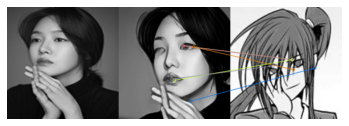

--------------------------------------------------------
순위 : 2
이름 : 채수빈
나이 : 28
이미지 점수 : 63.11
키워드 점수 : 99.51
합계 점수 : 81.31


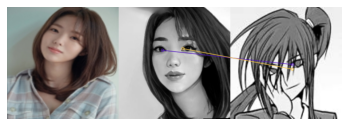

--------------------------------------------------------
순위 : 3
이름 : 김남주
나이 : 27
이미지 점수 : 62.8
키워드 점수 : 99.79
합계 점수 : 81.3


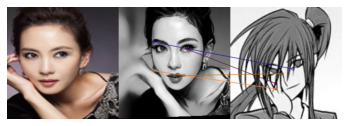

--------------------------------------------------------
순위 : 4
이름 : 남지현
나이 : 27
이미지 점수 : 62.68
키워드 점수 : 99.23
합계 점수 : 80.95


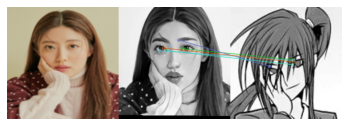

--------------------------------------------------------
순위 : 5
이름 : 혜리
나이 : 28
이미지 점수 : 62.02
키워드 점수 : 97.81
합계 점수 : 79.91


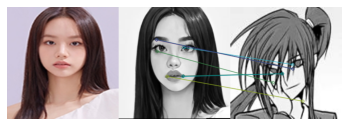

In [193]:
cImg = CImg()
cnt = 1

c_img = cv2.imread(f'../image_data/Webtoon/{user_input_title}_{user_input_cname}.jpg', flags=cv2.IMREAD_COLOR)

for i in top5_actors_df.values:
    name = i[0]
    age = i[1]
    image_score = round(i[2] * 100, 2)
    keyword_score = round(i[3] * 100, 2)
    total_score = round(i[4] * 100, 2)
    print('--------------' * 4)
    print(f'순위 : {cnt}')
    print(f'이름 : {name}\n나이 : {age}\n이미지 점수 : {image_score}\n키워드 점수 : {keyword_score}\n합계 점수 : {total_score}')
    
    actor_real_img = cv2.imread(f'../image_data/Actor/{name}.jpg', flags=cv2.IMREAD_COLOR)
    actor_real_img = cImg.img_resize(actor_real_img)
    actor_real_img = cImg.img_to_rgb(actor_real_img)
    actor_webtoon_img = cv2.imread(f'../image_data/Actor2Webtoon/webtoon_{name}.jpg', flags=cv2.IMREAD_COLOR)
    
    cImg.run(actor_webtoon_img, c_img, show=False)
    knn_img = cImg.get_knn_image()
    
    img_con = np.concatenate([actor_real_img, knn_img], axis=1)
    
    plt.imshow(img_con)
    plt.axis('off')
    plt.show()
    
    cnt += 1

## 7. 개선방향
- 데이터 재정비
- 이미지 비교 모델 성능 개선 -> 현재는 찾지 못해서 도움이 필요.
    - 이미지 유사성 비교 모델 성능 지표 마련
- 키워드 유사성 비교 모델 성능 개선
    - 키워드 유사성 비교 모델 성능 지표 마련

## 8. 아이디어
- 사진을 찍으면 이모티콘으로 만들어주는 것